In [ ]:
!pip install mxnet=="1.4.1"

In [ ]:
!pip install gluonts

In [2]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar
# from utils_gluonts11_deepstate import deep_state


INFO:root:Using CPU


In [3]:
dataname = "m4_monthly_micro"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_micro.


In [4]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [5]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'target': array([ 3396.89,  3257.99,  3158.49,  3176.81,  3157.27,  3108.64,
         3063.8 ,  3098.17,  3106.87,  3096.37,  3193.22,  3230.99,
         3329.66,  3278.32,  3228.59,  3196.76,  3178.63,  3210.04,
         3236.73,  3281.7 ,  3298.  ,  3292.78,  3283.29,  3283.5 ,
         3266.97,  3238.75,  3228.64,  3275.36,  3289.36,  3304.42,
         3386.32,  3449.33,  3480.2 ,  3488.49,  3489.8 ,  3514.08,
         3509.89,  3507.85,  3535.43,  3557.9 ,  3569.59,  3581.05,
         3568.18,  3565.69,  3606.74,  3631.37,  3675.48,  3681.79,
         3677.63,  3697.65,  3706.94,  3697.  ,  3702.05,  3703.11,
         3677.1 ,  3703.61,  3716.26,  3688.9 ,  3665.12,  3615.87,
         3594.32,  3593.57,  3573.24,  3569.07,  3599.18,  3554.01,
         3484.06,  3424.86,  3433.06,  3373.05,  3448.19,  3465.57,
         3465.6 ,  3485.96,  3497.15,  3530.69,  3557.28,  3557.31,
         3504.81,  3521.84,  3527.23,  3572.4 ,  362

### Plot Series

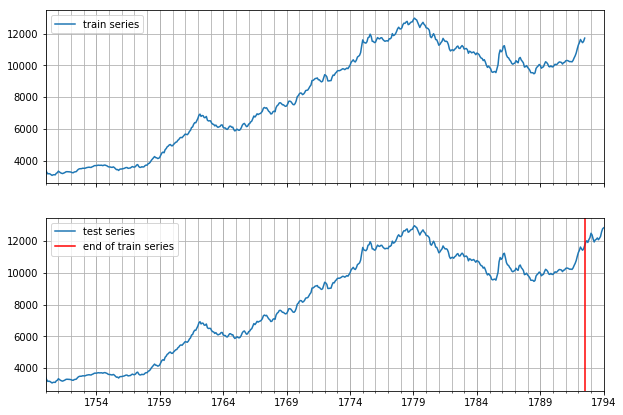

In [6]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [7]:
print("start:", dict(train_entry)["start"])
print("target:", dict(train_entry)["target"][:7])
print("feat_static_cat:", dict(train_entry)["feat_static_cat"])
print("length:", len(dataset.train))

start: 1750-01-31 00:00:00
target: [3396.89 3257.99 3158.49 3176.81 3157.27 3108.64 3063.8 ]
feat_static_cat: [1]
length: 10975


In [1]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepstate import DeepStateEstimator
from gluonts.model.seq2seq import MQRNNEstimator


INFO:root:Using CPU
INFO:root:Using CPU
INFO:root:Using CPU
INFO:root:Using CPU
INFO:root:Using CPU
INFO:root:Using CPU
INFO:root:Using CPU
INFO:root:Using CPU
INFO:root:Using CPU


In [11]:
#########################
### deepstate wrapper ###

data = "m4_monthly_micro"
seed = 42
epochs = 100
num_batches = 50
batch_size = 32


mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=num_batches,
    learning_rate=1e-3,
    batch_size=batch_size,
    )

# cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = MQRNNEstimator(
    trainer=trainer,
#     cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
#     use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = num_batches
# output["batch_size"] = batch_size

pd.DataFrame([output])

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.92it/s, avg_epoch_loss=1.39e+3]
INFO:root:Epoch[0] Elapsed time 1.685 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1389.395654
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.52it/s, avg_epoch_loss=1.3e+3]
INFO:root:Epoch[1] Elapsed time 1.821 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1302.810119
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.41it/s, avg_epoch_loss=1.7e+3]
INFO:root:Epoch[2] Elapsed time 1.825 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1697.406645
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.33it/s, avg_epoch_loss=1.72e+3]
INFO:root:Epoch[3] Elapsed time 1.709 seconds
INFO:root:Epoch[3] Evaluation metric 

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 34.24it/s, avg_epoch_loss=796]
INFO:root:Epoch[36] Elapsed time 1.466 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=795.536641
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.09it/s, avg_epoch_loss=1.01e+3]
INFO:root:Epoch[37] Elapsed time 1.316 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=1012.488553
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.85it/s, avg_epoch_loss=743]
INFO:root:Epoch[38] Elapsed time 1.324 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=742.902720
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.57it/s, avg_epoch_loss=617]
INFO:root:Epoch[39] Elapsed time 1.209 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=617.058558
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.96it/s, avg_epoch_loss=493]
INFO

100%|██████████| 50/50 [00:01<00:00, 40.01it/s, avg_epoch_loss=316]
INFO:root:Epoch[73] Elapsed time 1.254 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=315.664046
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.13it/s, avg_epoch_loss=200]
INFO:root:Epoch[74] Elapsed time 1.318 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=199.650251
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 35.75it/s, avg_epoch_loss=308]
INFO:root:Epoch[75] Elapsed time 1.403 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=307.703809
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 34.65it/s, avg_epoch_loss=222]
INFO:root:Epoch[76] Elapsed time 1.450 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=221.562102
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 35.22it/s, avg_epoch_loss=340]
INFO:root:Epoch[77] Elapsed time 1.426 seconds
INFO:

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,4.726608,0.363595,91.137494,0.368477,0.409155,42,100,50


# Study: 100/100

In [17]:
!jupyter nbconvert --output-dir="../html_outputs" --to html gluonts-mqrnn-estimator.ipynb

[NbConvertApp] Converting notebook gluonts-mqrnn-estimator.ipynb to html
[NbConvertApp] Writing 551921 bytes to ../html_outputs/gluonts-mqrnn-estimator.html


In [21]:
!jupyter nbconvert --output-dir="../html_outputs" --to html gluonts-mqrnn-estimator.ipynb

[NbConvertApp] Converting notebook gluonts-mqrnn-estimator.ipynb to html
[NbConvertApp] Writing 800605 bytes to ../html_outputs/gluonts-mqrnn-estimator.html


In [25]:
!jupyter nbconvert --output-dir="../html_outputs" --to html gluonts-mqrnn-estimator.ipynb

[NbConvertApp] Converting notebook gluonts-mqrnn-estimator.ipynb to html
[NbConvertApp] Writing 1068781 bytes to ../html_outputs/gluonts-mqrnn-estimator.html
